In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from abc import ABC, abstractmethod

In [2]:
class InputData():
    def get_training_data(self):
        data = np.genfromtxt('TrainingRidge.csv', delimiter=',', skip_header=1)
        x = data[:, [0, 1]]
        y = data[:, [2]]
        return x,y
    
    def get_validation_data(self):
        data = np.genfromtxt('ValidationRidge.csv', delimiter=',', skip_header=1)
        x = data[:, [0, 1]]
        y = data[:, [2]]
        return x,y

input_data = InputData() 
x, yt = input_data.get_training_data()
x_validation, yt_validation = input_data.get_validation_data()

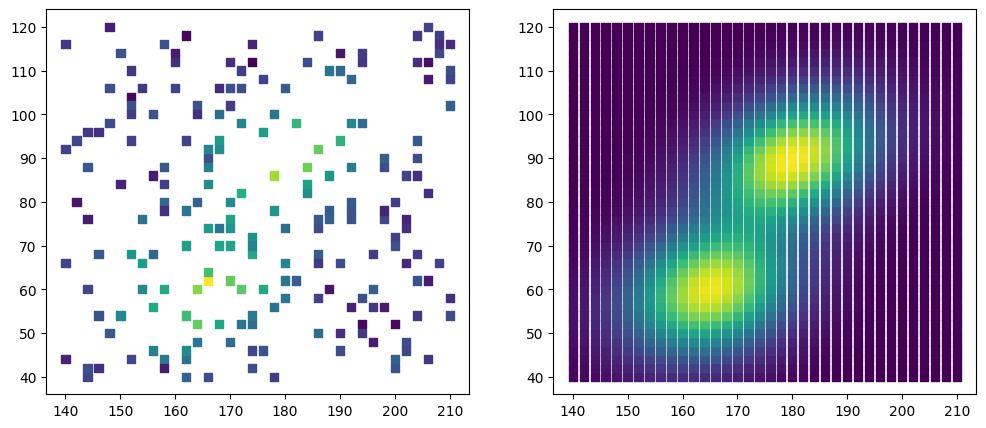

In [3]:
def plot_data(x1, y1, x2, y2):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    ax[0].scatter(x1[:, 0], x1[:, 1], c=y1, marker='s')
    ax[1].scatter(x2[:, 0], x2[:, 1], c=y2, marker='s')
    
plot_data(x, yt, x_validation, yt_validation)

In [4]:
x / x.max(0)

array([[0.66666667, 0.96666667],
       [0.94285714, 0.73333333],
       [0.82857143, 0.93333333],
       [0.8       , 0.43333333],
       [0.98095238, 0.36666667],
       [0.76190476, 0.93333333],
       [0.95238095, 0.58333333],
       [0.91428571, 0.9       ],
       [0.97142857, 0.45      ],
       [0.82857143, 0.56666667],
       [1.        , 0.91666667],
       [0.9047619 , 0.78333333],
       [0.7047619 , 1.        ],
       [0.94285714, 0.75      ],
       [0.77142857, 0.45      ],
       [0.9047619 , 0.38333333],
       [0.88571429, 0.48333333],
       [0.92380952, 0.43333333],
       [0.85714286, 0.88333333],
       [0.99047619, 0.55      ],
       [0.96190476, 0.63333333],
       [0.96190476, 0.4       ],
       [0.82857143, 0.43333333],
       [0.8       , 0.61666667],
       [0.84761905, 0.65      ],
       [0.94285714, 0.46666667],
       [1.        , 0.48333333],
       [0.68571429, 0.35      ],
       [0.88571429, 0.76666667],
       [0.72380952, 0.78333333],
       [0.

Eigenvalues:
 [391.3288 544.8523] 

Eigenvectors:
 [[-0.988923   -0.14842945]
 [ 0.14842945 -0.988923  ]] 

Diagonal matrix for inverse square root of Eigenvalues:
 [[0.0506 0.    ]
 [0.     0.0428]] 



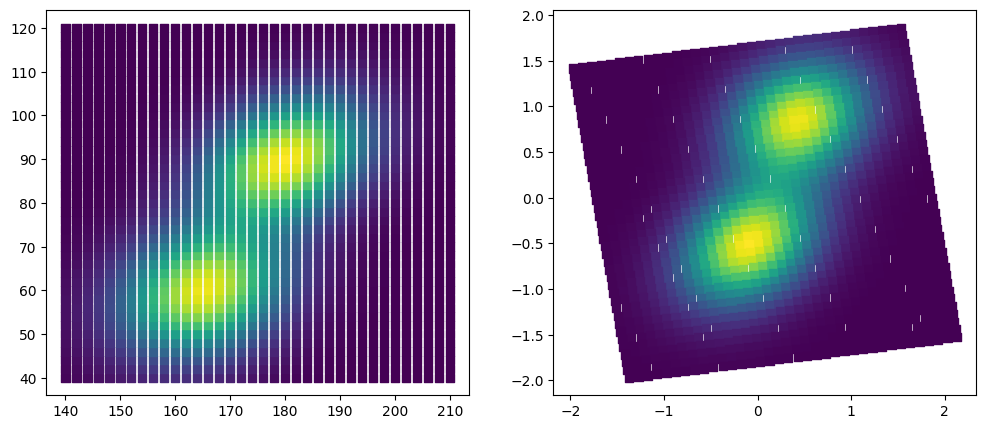

In [49]:
xc = x - np.mean(x, 0)
xc = xc.T
xc2 = x_validation - np.mean(x, 0) 
xc2 = xc2.T

xcov = np.cov(xc, rowvar=True, bias=True)
w,v = np.linalg.eig(xcov)
print("Eigenvalues:\n", w.real.round(4), '\n')
print("Eigenvectors:\n", v, '\n')

diagw = np.diag(1/(w**0.5))
diagw = diagw.real.round(4)
print("Diagonal matrix for inverse square root of Eigenvalues:\n", diagw, '\n')
 
xrot = np.dot(v, xc)
wpca = diagw @ v.T @ xc
wpca2 = diagw @ v.T @ xc2
wzca = v @ diagw @ v.T @ xc

plot_data(x_validation, yt_validation, wpca2.T, yt_validation)

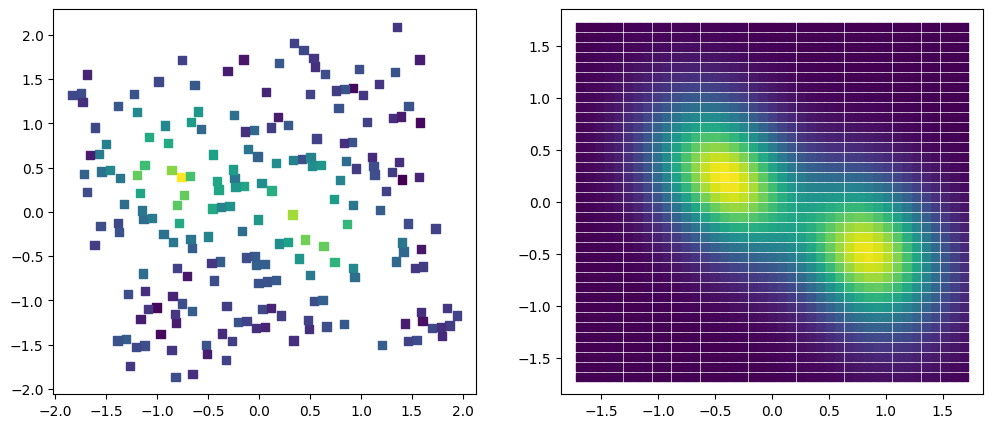

In [50]:
class Whitener(ABC):
    @abstractmethod
    def fit(self, x):
        pass
    
    @abstractmethod
    def apply(self, x):
        pass

class MyWhitener(Whitener):
    
    def fit(self, x_original):
        self.x_mean = x_original.mean(0)
        x_centered = x_original - self.x_mean
        
        C = np.cov(x_centered)
        w, self.E = np.linalg.eig(C)
        
        self.A = np.diag(w)

    def apply(self, x_original):
        x = x_original - self.x_mean
        return np.linalg.inv(np.sqrt(self.A)) @ self.E.T @ x 

class MyWhitener2(Whitener):
    
    def fit(self, x_original):
        self.x_mean = x_original.mean(0)
        x_centered = x_original - self.x_mean
        self.normalize_factor = x_centered.std(0)
        
        return (x_original - self.x_mean) / self.normalize_factor
    
    def apply(self, x_original):
        return (x_original - self.x_mean) / self.normalize_factor
     
class PCAWhitener(Whitener):
    
    def fit(self, x_original): 
        pass
    
    def apply(self, x_original):
        whitener = PCA(whiten=True)
        sphered_x = whitener.fit_transform(x_original)
        return sphered_x
    
       

whitener = PCAWhitener()
whitener.fit(x)
wx = whitener.apply(x)
wx_validation = whitener.apply(x_validation)

plot_data(wx, yt, wx_validation, yt_validation)

In [6]:
def make_monomials():
    m = []
    for d in range(10):
        for l in range(d+1):
            m.append([l, d-l])
    return np.array(m)

monomials = make_monomials()
monomials[:2]

array([[0, 0],
       [0, 1]])

In [7]:
xd = np.array([[0.5, -0.5], [0.3, -0.3], [0.2, -0.2]])
yd = np.array([[0.5], [0.3], [0.2]]) 
# yd = np.array([[50], [30], [20]]) 
wd = np.array([[-1], [1]])

print(xd.shape)
print(yd.shape)
print(wd.shape)

(3, 2)
(3, 1)
(2, 1)


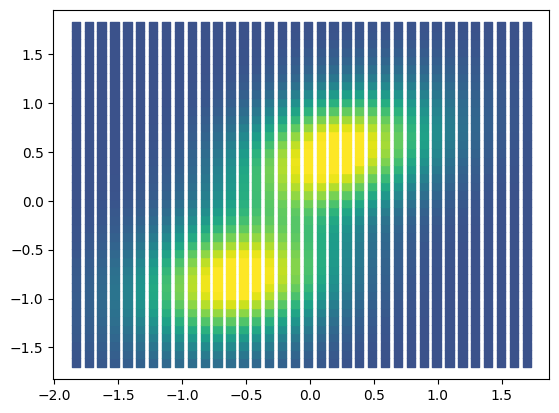

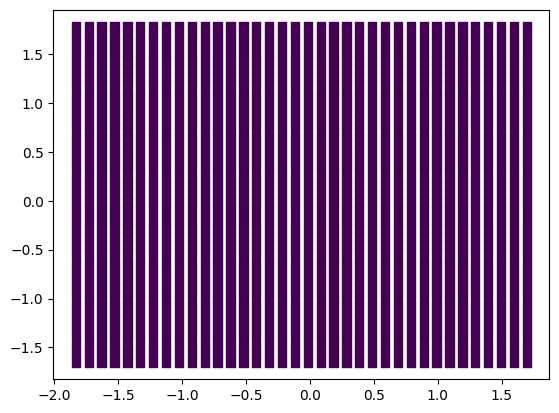

In [66]:
class Neuron():
    
    def __init__(self, w, monomial):
        self.w_old = w
        self.monomial = monomial
    
    def learn(self, X, yt):
        
#         print(X)
        y = self.output(X)

        error =  1/2 * (y - yt)**2
#         print(error.mean())
        error_prime = (y - yt)
        
        #                        delta  f(h)
        gradient_b = error_prime * (1)
        gradient_w = error_prime * (1 * self.apply_monomial(X) @ self.w_old)
        gradient = np.hstack([gradient_b, gradient_w])
        
#         print(y.mean())
#         print(yt.mean())
#         print(error_prime.mean())
#         print(gradient.mean(0))
#         print('--------')
#         print('gradient_b', gradient_b.shaTpe)
#         print('gradient_w', gradient_w.shape)
#         print('gradient', gradient.shape)
#         print('error_prime', error_prime.shape)
#         print('x monomial', (self.apply_monomial(X)).shape)
#         print('w_old', self.w_old.shape)

        step = 0.08 * gradient.mean(0)[:, np.newaxis]
        w_new = self.w_old - step
#         print('w_new', w_new.shape)
#         print('step', step.shape)
        self.w_old = w_new
        return w_new
    
    def apply_monomial(self, X):
        x1 = X[:, 0][:, np.newaxis]**self.monomial[0]
        x2 = X[:, 1][:, np.newaxis]**self.monomial[1]
        return np.hstack([x1, x2])
    
    def output(self, X):
        X = self.apply_monomial(X)
        y = X @ self.w_old
#         y = X @ np.array([[2], [-2]])
#         print(y)
        return y 

def create_and_train_monomial_neuron(monomial):
#     w = np.array([[-2.5], [5.2]])
    w = np.random.uniform(-0.5, 0.5, 2)[:, np.newaxis]
    neuron = Neuron(w, monomial)

    for i in np.arange(10):
        neuron.learn(wx_validation, yt_validation)
        
    return neuron

neuron = create_and_train_monomial_neuron(monomials[9])

plt.scatter(wx_validation[:, 0], wx_validation[:, 1], c=yt_validation, marker='s', vmin=0, vmax=40)
plt.show()
plt.scatter(wx_validation[:, 0], wx_validation[:, 1], c=neuron.output(wx_validation), vmin=0, vmax=40, marker='s')
plt.show()

# neuron = Neuron(wd, monomials[2])
# for _ in np.arange(100):
#     neuron.learn(xd, yd)

# monomials = monomials[:]
# fig, axs = plt.subplots(nrows=len(monomials)//4, ncols=4, figsize=(15,4*len(monomials)//4))
# for ax, monomial in zip(axs.ravel(), monomials):
#     neuron = create_and_train_monomial_neuron(monomial)
#     ax.scatter(wx_validation[:, 0], wx_validation[:, 1], c=neuron.output(wx_validation), marker='s')
#     ax.set_title(f'$x^{monomial[0]}y^{monomial[1]}$')

In [17]:
wx_validation.shape, yt.shape

((1476, 2), (200, 1))